In [3]:
### Import libraries 

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

matplotlib.style.use('ggplot')
sns.set_style("whitegrid")

import scipy


DataTransformerRegistry.enable('json')

In [4]:
#%%% load the dataset 

df = pd.read_csv("marketing_data.csv")

print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   2240 non-null   int64 
 1   Year_Birth           2240 non-null   int64 
 2   Education            2240 non-null   object
 3   Marital_Status       2240 non-null   object
 4    Income              2216 non-null   object
 5   Kidhome              2240 non-null   int64 
 6   Teenhome             2240 non-null   int64 
 7   Dt_Customer          2240 non-null   object
 8   Recency              2240 non-null   int64 
 9   MntWines             2240 non-null   int64 
 10  MntFruits            2240 non-null   int64 
 11  MntMeatProducts      2240 non-null   int64 
 12  MntFishProducts      2240 non-null   int64 
 13  MntSweetProducts     2240 non-null   int64 
 14  MntGoldProds         2240 non-null   int64 
 15  NumDealsPurchases    2240 non-null   int64 
 16  NumWeb

In [5]:
#%% Cleaning up column names 

df.columns = df.columns.str.replace(' ', '')

# converting income to float for analysis 
df['Income'] = df['Income'].str.replace('$', '')
df['Income'] = df['Income'].str.replace(',', '').astype('float')

# change dt_customer column to datetime format 
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])

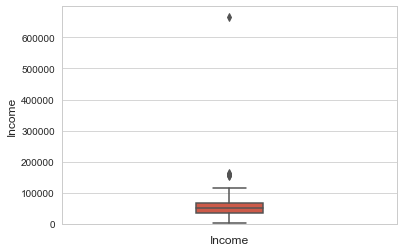

In [6]:
#%%  EDA

# check for null values  


# Income column has 24 null records, we will explore how data is distributed and decide how to fill this null values 

sns.histplot(data = df, x = "Income")

# Values are distributed mostly within $0 - 100000 range, there are some outliers 


sns.boxplot(y = df['Income'],width= 0.2)

# we will use median value to fill na ,avoiding effect of outliers 

df['Income'] = df['Income'].fillna(df['Income'].median())

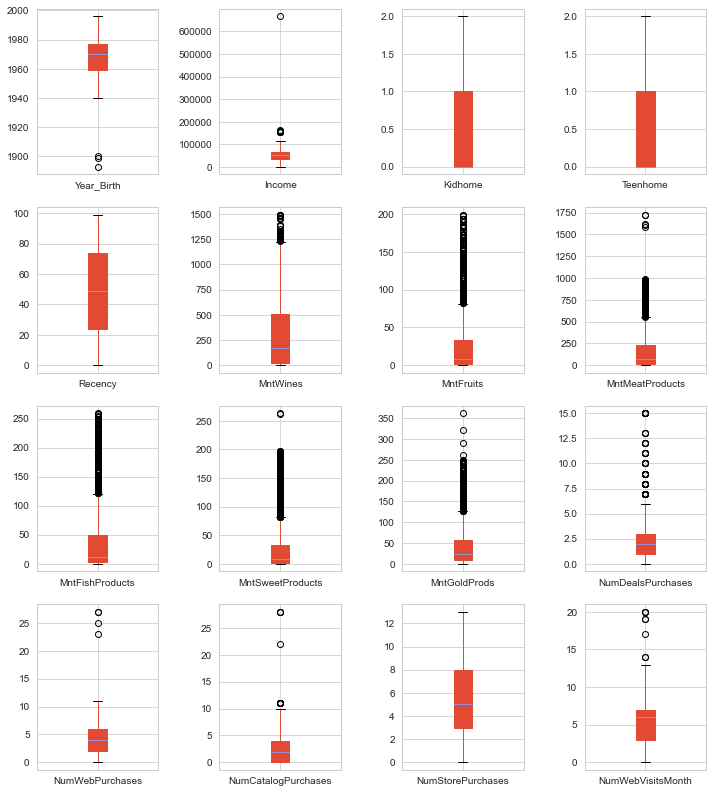

In [7]:
#%% finding features that contain outliers 

plot_df = df.drop(columns=['ID', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response', 'Complain']).select_dtypes(include=np.number)

# subplots
plot_df.plot(subplots=True, layout=(4,4), kind='box', figsize=(12,14), patch_artist=True)
plt.subplots_adjust(wspace=0.5);

# we can notice there are anamolies in birth year, we will remove records where birth year <= 1900 

df = df[df['Year_Birth'] > 1900].reset_index(drop=True)

In [8]:
#%% Construct new variables that will be helpful in analysis 

# we will extract year from date variable

df['join_year'] = pd.DatetimeIndex(df['Dt_Customer']).year

# compute total purchases column by adding different purchase columns 

purchases_var = [col for col in df.columns if 'Purchases' in col]
df['total_purchases'] = df[purchases_var].sum(axis=1)

# Compute total amount spent column 
amount_cols = [col for col in df.columns if 'Mnt' in col]
df['total_amount'] = df[amount_cols].sum(axis=1)

# Compute Number of accepted campaigns 
campaigns_var = [col for col in df.columns if 'Cmp' in col] + ['Response'] # 'Response' is for the latest campaign
df['total_campaigns_accp'] = df[campaigns_var].sum(axis=1)

# compute number of dependents from teen and kids column 
df['dependents'] = df['Kidhome'] + df['Teenhome']

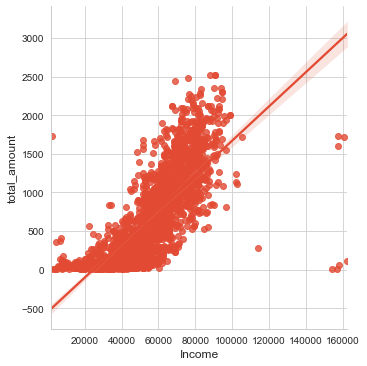

In [9]:
#%% looking for pattern

# Looking for effect of high income on total amount spent 

sns.lmplot(x='Income', y='total_amount', data=df[df['Income'] < 200000])

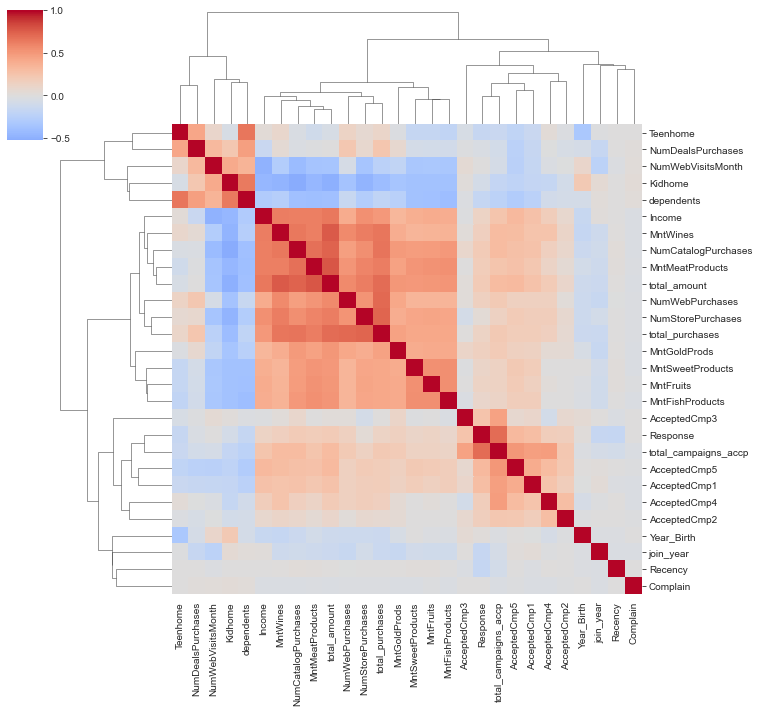

In [10]:
#%% # Find clusters using seaborn cluster map 

#calculate correlation matrix
## using non-parametric test of correlation (kendall), since some features are binary
corr_matrix = df.drop(columns='ID').select_dtypes(include=np.number).corr(method = 'kendall')

# plot clustered heatmap of correlations
sns.clustermap(corr_matrix, cbar_pos=(-0.05, 0.8, 0.05, 0.18), cmap='coolwarm', center=0);



# Takeaways : 
    # Number of web vists is not correlated with web purchases
    # But number of deals purchased is correlated with web vists indicating that deals can stimulate purchases 
    # there is a positive impact on number of deals when having kids & teens 

#  Total Purchase Analysis 

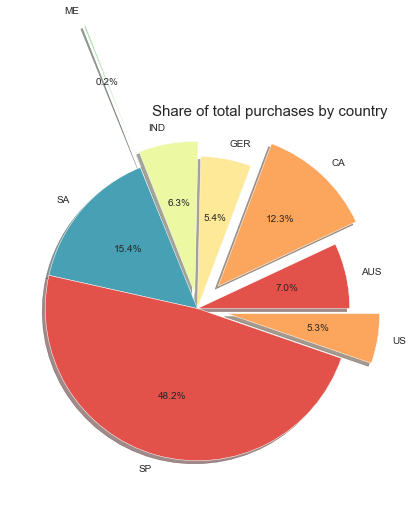

In [34]:

# we look into proportion of purchases made 

pm = df[['total_purchases', 'Country']].groupby(['Country']).agg([sum])

sns.set_palette('Spectral')
plt.figure(figsize = (7, 7))
plt.pie(pm['total_purchases']['sum'], labels = pm.index, explode = (0, 0.2, 0, 0.1, 1, 0, 0, 0.2),
        shadow = True, autopct = '%1.1f%%')
plt.title(label  = 'Share of total purchases by country',fontsize=15, pad='2.0',loc="right")
plt.show()

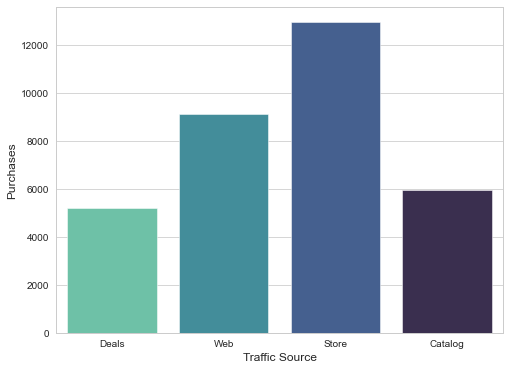

In [22]:
#%%  purchases made through each source 

plt.figure(figsize = (8, 6))
purchases = df[['NumDealsPurchases', 'NumWebPurchases', 'NumStorePurchases', 'NumCatalogPurchases']].agg([sum])

sns.barplot(x = purchases.T.index, y = purchases.T['sum'], palette = 'mako_r')
plt.gca().set_xticklabels(['Deals', 'Web', 'Store', 'Catalog'])
plt.xlabel('Traffic Source')
plt.ylabel('Purchases')
plt.show()

[Text(0.5, 0, 'Average amount spent')]

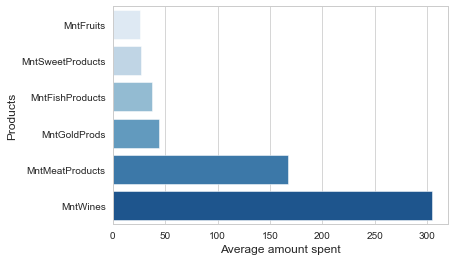

In [21]:
#%% Average spending on products 

spending = pd.DataFrame(round(df[amount_cols].mean(), 1), columns=['Average']).sort_values(by='Average').reset_index()


ax = sns.barplot(x='Average', y='index', data=spending, palette='Blues')
ax.set(ylabel = 'Products')
ax.set(xlabel = 'Average amount spent')

Text(0, 0.5, 'Number of Purchases')

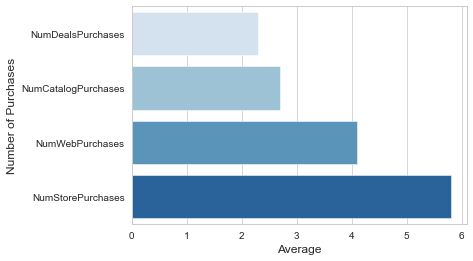

In [14]:
#%% performace of channels 

channels = pd.DataFrame(round(df[purchases_var].mean(), 1), columns=['Average']).sort_values(by='Average').reset_index()

# plot
ax = sns.barplot(x='Average', y='index', data=channels, palette='Blues')
plt.ylabel('Number of Purchases')


# Marketing Campaign analysis 



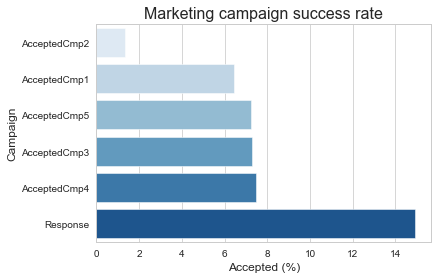

In [15]:
#%% sucessful campaign 

success = pd.DataFrame(df[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']].mean()*100, 
                           columns=['Percent']).reset_index()

# plot
sns.barplot(x='Percent', y='index', data= success.sort_values('Percent'), palette='Blues')
plt.xlabel('Accepted (%)')
plt.ylabel('Campaign')
plt.title('Marketing campaign success rate', size=16);

In [16]:
#%% Campaign Conversion rate by country

conversion_rate = df.groupby('Country').agg(
    Total_user_count = pd.NamedAgg(column = 'ID', aggfunc= 'count'),
    Total_campaign1_accept = pd.NamedAgg(column='AcceptedCmp1', aggfunc = sum),
    Total_campaign2_accept = pd.NamedAgg(column='AcceptedCmp2', aggfunc = sum),
    Total_campaign3_accept = pd.NamedAgg(column='AcceptedCmp3', aggfunc = sum),
    Total_campaign4_accept = pd.NamedAgg(column='AcceptedCmp4', aggfunc = sum),
    Total_campaign5_accept = pd.NamedAgg(column='AcceptedCmp5', aggfunc = sum)
    )

conversion_rate['Total_acceptances'] = conversion_rate.iloc[:,1:6].sum(axis = 1)

conversion_rate['conversion_rate'] = conversion_rate['Total_acceptances']/conversion_rate['Total_user_count']

conversion_rate.style.background_gradient(subset='conversion_rate')

,Total_user_count,Total_campaign1_accept,Total_campaign2_accept,Total_campaign3_accept,Total_campaign4_accept,Total_campaign5_accept,Total_acceptances,conversion_rate
Country,,,,,,,,
AUS,160,7,0,9,6,13,35,0.218750
CA,268,18,6,18,24,21,87,0.324627
GER,120,7,2,10,11,8,38,0.316667
IND,147,7,2,13,11,6,39,0.265306
ME,3,0,0,1,0,0,1,0.333333
SA,336,20,4,21,20,21,86,0.255952
SP,1094,78,16,83,89,88,354,0.323583
US,109,7,0,8,6,5,26,0.238532


Text(0.5, 1.0, 'Feature importance using Lasso Model')

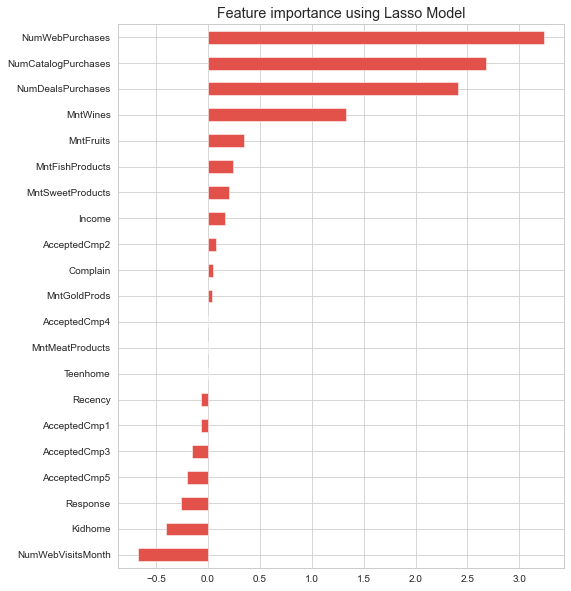

In [37]:
#%% building model 

from sklearn.linear_model import Lasso
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.feature_selection import f_regression, f_classif, chi2, RFE, VarianceThreshold, SelectPercentile
from sklearn.pipeline import FeatureUnion, Pipeline


# Let's clear redundant features
X_numeric = df.drop(['NumStorePurchases','Dt_Customer','Year_Birth','ID','total_purchases','Country','total_amount','Education','Marital_Status','join_year','dependents','total_campaigns_accp'], axis=1)

# Focus on number of store purchases
y = df[['total_purchases']]


# 1) Preoprocess
# Impute null values
Imputer = KNNImputer(missing_values=np.nan)

# Standardize numeric columns
Scaler = StandardScaler()

numeric_pipe = Pipeline([("Impute", Imputer),
                         ("Scale", Scaler)])

X_numeric_preprocessed = numeric_pipe.fit_transform(X_numeric)

# 2) Building the models
lasso = Lasso(alpha=0.01).fit(X_numeric_preprocessed, y)


coef = pd.Series(lasso.coef_, index = X_numeric.columns)

#3) plot important varaibles 
imp_coef = coef.sort_values()
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

--Considering Lasso coefficient, we see that

1. Features having positive effect to the number of store purchases in decreasing order is 'MntWines', 'NumDealsPurchases', 'NumWebPurchases', 'MntFruits', 'MntFishProducts'.
2. Features having negative effect to the number of store purchases in decreasing order is NumWebVisitsMonth, Kidhome, Response.   